# Estudio de las Ventas de una Ferretería

>Autor: Diana Chacón Ocariz

## Resumen

**Estudio de las ventas del 01/01/2020 al 20/02/2022:**

1. 3 métricas nos interesan:
    1. Ventas en USD
    2. Volumen de Ventas
    3. Afluencia de Clientes (dada por la cantidad de facturas)
1. De manera general las ventas han ido aumentando, en particular a partir del 2do semestre del 2021.
1. Este año 2022 empezó con fuerza y hemos tenido las mayores ventas del período
1. Los días de más afluencia de clientes son los martes y miércoles, seguido de los jueves y lunes. Principalmente en las mañanas de 10am a 12pm.
1. Dentro de las líneas de productos más vendidas (ventas en USD y/o volumen de ventas), se encuentran aquellas relacionadas con los sistemas de riego, lo que confirma la especialización de la empresa en este tipo de productos.
1. De los 3.000 productos en existencia, 236 son considerados **indispensables**, pues registran ventas en al menos el 75% de los meses del período estudiado.
1. De los 236 productos indispensables, 37 podrían entrar en rotura de stock durante marzo del 2022.



## Detalles del Análisis

In [33]:
# Librerías utilizadas

# Librerías para el manejo de directorios
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd

# Librerías para graficar 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import squarify

%matplotlib inline


In [34]:
# Carga de datos

BASE_DIR = Path.cwd()
BASE_DIR

df_ventas = pd.read_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", engine='fastparquet')
df_stock = pd.read_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", engine='fastparquet')

df_ventas_linea_prod = df_ventas.query('fecha > "2020-12-31"').loc[:,['fecha', 'cod', 'producto', 'cantidad', 'monto_dolar']]
df_ventas_linea_prod = pd.merge(df_ventas_linea_prod, df_stock, on=['cod', 'producto'], how='outer')


In [35]:
# Estilo y colores para los gráficos

plt.style.use('seaborn-colorblind')
plt.rcParams['lines.linewidth'] = 1.5

VERDE = '#39894d' 
AZUL = '#2649e8'  
AMARILLO = '#f1d065' 

# Funciones generales

# Formateado de texto
def formato_titulo(texto):
    subray = '=' * (len(texto))
    print("\033[1;32m"+texto)
    print(subray)
    print("\033[0;m")


In [36]:
# Funciones para crear gráficos de Altair


# graf_barras_ventas_dol
# Crea un gráfico de barras de ventas en $ en función de diferentes
# intervalos de tiempo
#
# Parámetros: 
#     df: DataFrame a utilizar
#     x: Datos para el eje de las x. Generalmente es el intervalo de tiempo
#     tooltip: Lista con los parámetros del tooltip
#     titulo: Título del gráfico
#     dx: Entero para ajustar horizontalmente la posición del texto sobre las barras
def graf_barras_ventas_dol(df, x, tooltip, titulo, dx):
    
       
    barras = alt.Chart(df).mark_bar().encode(
                    x=x,
                    y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                      axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                    color=alt.Color(
                        'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen'),
                        legend=alt.Legend(title="Ventas en $")),
                    tooltip=tooltip,
                    ).properties(title=titulo,
                             width=800, 
                             height=300
                    )
    
    textos = barras.mark_text(dx=dx, dy=-10, fill='black').encode(
             text = alt.Text('sum(monto_dolar):Q', format=',.5', title = 'Ventas en $')
                    )
        
    grafico_final = barras + textos
    
    return grafico_final

# graf_sectores_linea
# Crea un gráfico de sectores de las líneas de productos
#
# Parámetros: 
#     df: DataFrame a utilizar
#     theta: Datos que se van a graficar
#     texto: Texto que se mostrará en el cada sector del gráfico
#     titulo: Título del gráfico
def graf_sectores_linea(df, theta, texto, titulo):

    base = alt.Chart(df).encode(
        theta=theta, 
        color=alt.Color("linea:N"),
        tooltip=[alt.Tooltip('linea:N', title='Línea de Producto'),
                 alt.Tooltip('sum(monto_dolar):Q', format='$,.5', title='Ventas en $'),
                 alt.Tooltip('sum(cantidad):Q', format=',.5', title='Volumen de Ventas')]
    ).properties(title=titulo)

    pie = base.mark_arc(outerRadius=130, innerRadius=40)

    text = base.mark_text(radius=110, size=10, fill='black').encode(
           text=texto
           )
    
    grafico = pie + text

    return grafico

In [37]:
# Resumen General de las Ventas en $

df_ventas_dol = df_ventas.groupby('fecha').monto_dolar.sum().reset_index()
df_ventas_fecha = df_ventas.pivot_table(index='fecha',
                                       aggfunc={'monto_dolar': sum, 
                                                'cantidad': sum,
                                                'num': 'nunique'})

total_dias = df_ventas_dol.fecha.nunique()
num_meses = df_ventas_dol.fecha.dt.strftime('%m-%Y').nunique()

max_ventas = df_ventas.monto_dolar.max()
total_ventas_dol = df_ventas_dol.monto_dolar.sum()
total_faturas = df_ventas_fecha.num.sum()
promedio_diario =  total_ventas_dol / total_dias
promedio_mensual = total_ventas_dol / num_meses

formato_titulo('Resumen General de las Ventas en $')
print('El período de estudio va de:', df_ventas_dol.fecha.min(), 'a', df_ventas_dol.fecha.max())
print('El total de ventas en $ del período es:', round(total_ventas_dol, 2))
print('El N° de Facturas emitidas durante el período es:', round(total_faturas, 2))
print('El promedio mensual de ventas en $ es:', round(promedio_mensual, 2))
print('El promedio diario es:', round(promedio_diario, 2))


Resumen General de las Ventas en $

El período de estudio va de: 2020-01-06 00:00:00 a 2022-02-26 00:00:00
El total de ventas en $ del período es: 432128.73
El N° de Facturas emitidas durante el período es: 25880
El promedio mensual de ventas en $ es: 16620.34
El promedio diario es: 706.09


In [38]:
# Calculamos diferentes partes de la fecha

df_ventas_dol['año'] = df_ventas_dol.fecha.dt.year
df_ventas_dol['mes_año'] = df_ventas_dol.fecha.dt.strftime('%m-%Y')
df_ventas_dol['dia_semana'] = df_ventas_dol.fecha.dt.weekday
df_ventas_dol['dia_mes'] = df_ventas_dol.fecha.dt.day

x=alt.X('yearmonth(fecha):T', title='Mes y Año', axis = alt.Axis(labelAngle=0, labelFontSize=14))
tooltip=[alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
         alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $', format='$,.5')]
titulo='Ventas en $ por Mes'

graf_barras_ventas_dol(df_ventas_dol, x, tooltip, titulo, 15)

alt.LayerChart(...)

La evolución de las ventas en USD por mes muestra un aumento siginificativo a partir del 2do semestre del 2021. 

Los picos observados en mayo y octubre del 2020 corresponden a ventas excepcionales que se registraron en esos meses.

Es de resaltar que los meses con mayores ventas del período, corresponden a los meses que van del 2022.

In [39]:
mapa = alt.Chart(df_ventas_dol).mark_rect().encode(
                x=alt.X('dia_mes:O', title='Días del mes', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Mes y Año', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen'), legend=alt.Legend(title="Ventas en $")),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', format=',.5', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

Cada cuadrito corresponde a un día de venta en USD. Mientras más oscuro/verde, mayor las ventas. Los días en blanco corresponden a días sin ventas (fines de semana, feriados, etc.).

Las bajas ventas los primeros meses del 2020 se explican por los numerosos días sin ventas, debidos a la pandemia y feriados como el carnaval y semana santa.

Los cuadros más oscuro corresponden al 25/05/2020 y el 16/10/2020 donde se registraron ventas excepcionales.

A partir de julio del 2021 comenzamos a ver un poco más de cuadros oscuros, es decir, un aumento en las ventas.

En 2020 podemos observar mayores ventas en la 2da quincena de los meses. Pero a partir de julio del 2021, las ventes se vuelven más uniformes a lo largo de todo el mes.

In [40]:
x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14))
tooltip=[alt.Tooltip('day(fecha):T', title='Día'),
         alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $', format='$,.5')]
titulo='Ventas en $ por Día de la Semana'

graf_barras_ventas_dol(df_ventas_dol, x, tooltip, titulo, 60)

alt.LayerChart(...)

Los lunes y viernes son los días donde observamos mayores ventas. Los sábados es normal tener menos ventas porque sólo se trabaja medio día. Curiosamente el jueves es un día con pocas ventas.

Text(0.5, 0, 'Día de la Semana')

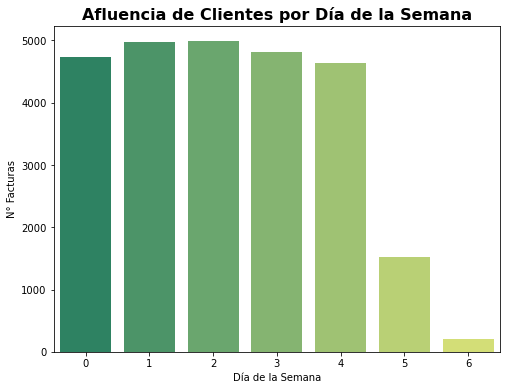

In [41]:
# Utilizamos nunique para contabilizar sólo una vez cada referencia de factura
# Descomponemos la fecha

df_n_fact = df_ventas.loc[:,['fecha_comp', 'fecha', 'num']]

df_n_fact['mes'] = df_n_fact.fecha_comp.dt.month
df_n_fact['año'] = df_n_fact.fecha_comp.dt.year

df_n_fact['dia_semana'] = df_n_fact.fecha_comp.dt.weekday
df_n_fact['dia_mes'] = df_n_fact.fecha_comp.dt.day

df_n_fact['hora'] = df_n_fact.fecha_comp.dt.hour

# N° de facturas para cada día de la semana
df_cl_dias = df_n_fact.pivot_table('num', index='dia_semana', aggfunc={'num':'nunique' }) 
df_cl_dias = df_cl_dias.reset_index()

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=df_cl_dias, x='dia_semana', y='num', palette='summer')

ax.set_title('Afluencia de Clientes por Día de la Semana', fontsize=16, weight='bold')
ax.set_ylabel('N° Facturas')
ax.set_xlabel('Día de la Semana')

Martes y Miércoles son los días con mayor afluencia de clientes, seguidos del jueves y el lunes. Hacia el fin de semana disminuye la afluencia.

Text(0.5, 0, 'Hora del Día')

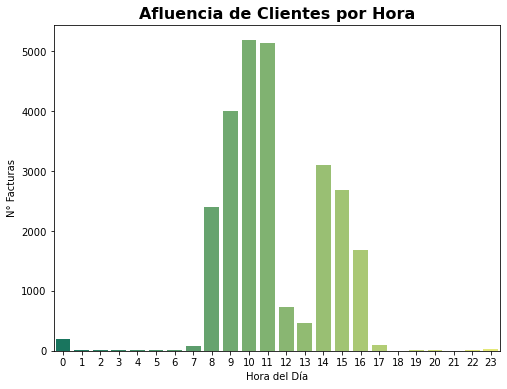

In [42]:
# Horas de más afluencia
df_cl_hora = df_n_fact.pivot_table('num', index='hora', aggfunc={'num':'nunique' }) 
df_cl_hora = df_cl_hora.reset_index()

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=df_cl_hora, x='hora', y='num', palette='summer')

ax.set_title('Afluencia de Clientes por Hora', fontsize=16, weight='bold')
ax.set_ylabel('N° Facturas')
ax.set_xlabel('Hora del Día')

En cuanto a las horas, definitivamente las mañanas son más concurridas, en particular de 10am a 12pm.

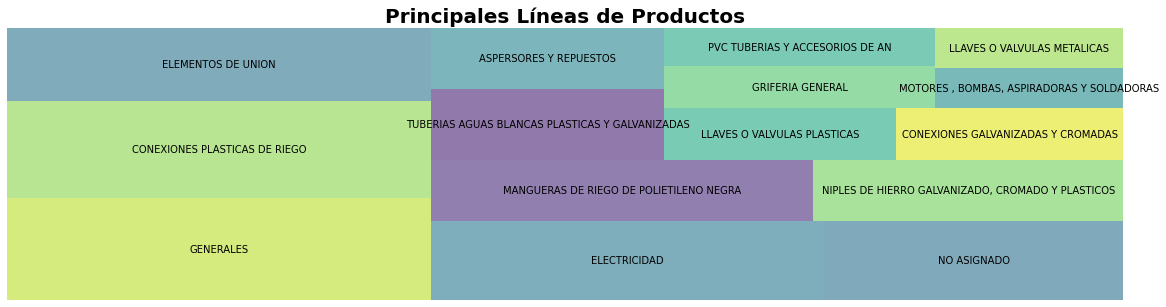

In [43]:
df_linea = df_ventas_linea_prod.copy()
df_linea.dropna(inplace=True)

# Por cada línea de producto: Ventas en volumen (cantidad), N° de productos (producto) 
# y total de Ventas en $ (monto_dolar)
df_linea_general = df_linea.pivot_table(index='linea',
                                        aggfunc={'monto_dolar':sum,
                                                 'producto':'nunique',
                                                 'cantidad':sum})

# Definimos la columna rango para seleccionar las 15 líneas con más ventas en $ y/o volumen
df_linea_general['rango'] = df_linea_general.cantidad + df_linea_general.monto_dolar

df_linea_general.cantidad = round(df_linea_general.cantidad, 2)
df_linea_general.monto_dolar = round(df_linea_general.monto_dolar, 2)

df_linea_top_15 = df_linea_general.reset_index().sort_values(['rango'], ascending=False).head(15)

with plt.style.context('seaborn-colorblind'):

    fig, ax = plt.subplots(figsize=(20,5))

    labels = df_linea_top_15['linea']
    sizes = df_linea_top_15['rango']
    squarify.plot(sizes, label=labels, alpha=0.6)

    plt.title('Principales Líneas de Productos',fontsize=20, fontweight='bold') 
    plt.axis('off')
    plt.show()

Estas son las 15 principales líneas de producto (de un total de 34). Son las más importantes porque generan la mayor cantidad de ventas en USD y/o en volumen.

Las líneas:
- Conexiones plásticas de riego
- Mangueras de riego de polietileno
- Aspersores y respuestos
- Motores, bombas, aspiradoras y soldaduras

Incluyen los productos utilizados en los acueductos y sistemas de riego.

Esto confirma que la empresa es vista por los clientes como especialista en esta materia.

In [44]:
df_linea_grafico = df_linea_general.reset_index()

total_dol = df_linea_grafico.monto_dolar.sum()
total_vol = df_linea_grafico.cantidad.sum()

df_linea_grafico['porcent_dolar'] = df_linea_grafico.apply(lambda row: round((row['monto_dolar'] / total_dol), 4), 
                                                           axis = 1)

df_linea_grafico['porcent_vol'] = df_linea_grafico.apply(lambda row: round((row['cantidad'] / total_vol), 4), 
                                                           axis = 1)

df_linea_grafico_dolar = df_linea_grafico.sort_values('monto_dolar', ascending=False).head(10)
df_linea_grafico_volumen = df_linea_grafico.sort_values('cantidad', ascending=False).head(10)

theta = alt.Theta("monto_dolar:Q", stack=True)
texto = alt.Text('porcent_dolar:Q', format='.2%')
titulo='Top 10 de la Líneas de Producto Más Vendidas en USD'

graf_sectores_linea(df_linea_grafico_dolar, theta, texto, titulo)

alt.LayerChart(...)

In [45]:
theta = alt.Theta("cantidad:Q", stack=True)
texto = alt.Text('porcent_vol:Q', format='.2%')
titulo='Top 10 de la Líneas de Producto Más Vendidas en Volumen'

graf_sectores_linea(df_linea_grafico_volumen, theta, texto, titulo)

alt.LayerChart(...)

Definimos un **producto indispensable** aquel que se vende regularmente y no puede faltar.

Para identificarlos, calculamos las ventas mensuales de cada producto. Aquellos que tuvieron ventas en al menos 75% de los meses del período (11 meses de 14), los consideramos indispensables. 

Son 236 y esta es la lista así como la cantidad por línea de producto:

In [46]:
# Calculamos cuantos meses del período cada producto tuvo ventas
# Difinimos como un producto indispensable aquel que tiene ventas regulares
# por ejemplo el 75% de los meses del período

def calculo_mes_con_ventas(row):
    total = 0
    
    for column in row: 
        if column:
            total = total + 1
    
    return total

df_ventas_prod = df_ventas_linea_prod.copy()

df_ventas_prod['mes_año'] = df_ventas_prod.fecha.dt.strftime('%m-%Y')
df_ventas_prod_mes = df_ventas_prod.pivot_table(index='cod',
                                               columns='mes_año',
                                               fill_value=0,
                                               aggfunc={'cantidad':sum})


df_ventas_prod_mes['mes_ventas'] = df_ventas_prod_mes.apply(lambda row: calculo_mes_con_ventas(row), 
                                              axis = 1)

min_meses = df_ventas_prod['mes_año'].nunique() * .75

df_ventas_prod_mes = df_ventas_prod_mes[ df_ventas_prod_mes['mes_ventas'] > min_meses ]

df_promed_ventas_prod = df_ventas_prod_mes.mean(axis = 1).reset_index()
df_promed_ventas_prod.columns=['cod', 'promedio']
df_promed_ventas_prod.promedio = round(df_promed_ventas_prod.promedio)

df_indispensables = df_stock[df_stock.cod.isin(df_ventas_prod_mes.index)]
df_indispensables = pd.merge(df_indispensables, df_promed_ventas_prod, on='cod')
df_indispensables

,cod,producto,linea,stock,fecha_stock,promedio
0,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,GENERALES,15.50,2022-03-03,4.0
1,00005,"NIPLE PLASTICO 1"" * 13CMS","NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",2.00,2022-03-03,39.0
2,00008,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,ALAMBRES Y MALLAS,8.75,2022-03-03,15.0
3,00010,"LLAVE 1/2"" ESFERICA GRINACA COLOMBIA",LLAVES O VALVULAS METALICAS,20.00,2022-03-03,5.0
4,00012,BAILARINA PUNTO NEGRO AGRO APN,ASPERSORES Y REPUESTOS,95.00,2022-03-03,19.0
...,...,...,...,...,...,...
231,06114,CEMENTO BLANCO (POR KG) ARGOS COLOMBIANO,CONSTRUCCIÓN,105.00,2022-03-03,12.0
232,06196,"ABRAZADERA METALICA 3/8"" 6MM-13MM",ELEMENTOS DE UNION,91.00,2022-03-03,12.0
233,06300,"CURVA 3/4"" NEGRA POLIETILENO ELECTRICIDAD ECON...",GENERALES,239.00,2022-03-03,10.0
234,06306,"REGADOR 1/2"" MINI WLOBBER MINI BAILARINA DIAME...",ASPERSORES Y REPUESTOS,76.00,2022-03-03,36.0


In [47]:
df_indispensables.groupby('linea').cod.count().sort_values(ascending=False)

linea
CONEXIONES PLASTICAS DE RIEGO                        49
GENERALES                                            24
ELEMENTOS DE UNION                                   24
NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS    19
ELECTRICIDAD                                         17
CONEXIONES GALVANIZADAS Y CROMADAS                   17
PVC TUBERIAS Y ACCESORIOS DE AN                      15
GRIFERIA GENERAL                                     11
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS      11
NO ASIGNADO                                           8
DISCOS                                                5
ASPERSORES Y REPUESTOS                                5
LLAVES O VALVULAS METALICAS                           5
LLAVES O VALVULAS PLASTICAS                           5
CHUCHERIAS                                            4
MECHAS, BROCAS, SIERRA COPA                           3
SEGURIDAD & HIGIENE                                   2
HERRAMIENTAS MANUALES                     

Esta es la lista de los productos indispensables que podrían entrar en **rotura de stock** durante el mes de marzo 2022, es decir, la cantidad en stock, es menor al promedio mensual de ventas:

In [48]:
# Productos que podrían entrar en rotura de stock al ser
# el promedio de ventas mensual mayor a la cantidad en stock

df_rotura = df_indispensables.query(' stock < promedio ')
df_rotura['faltan'] = df_rotura.promedio - df_rotura.stock
df_rotura = df_rotura.sort_values('faltan', ascending=False)
df_rotura.loc[:,['cod', 'producto', 'promedio', 'stock', 'faltan']]

/home/diana/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,cod,producto,promedio,stock,faltan
163,02584,"LLAVE PLASTICA 1/2"" ROSCADA",62.0,0.00,62.00
154,02282,"TORNILLO DRYWALL Nº8*2""",83.0,39.00,44.00
1,00005,"NIPLE PLASTICO 1"" * 13CMS",39.0,2.00,37.00
39,00312,"RIEGO ABRAZADERA PLASTICA 40MM * 3/4"" AGRO/ F....",66.0,36.00,30.00
100,00901,"NIPLE PLASTICO 3/4"" * 70 CTMS AZUL/GRIS CLASE A",40.0,19.00,21.00
60,00468,"CABILLA 3/8"" 10MM * 6 MTRS ESTRIADA (POR UNIDAD)",32.0,12.00,20.00
140,01697,"NIPLE PLASTICO 1/2"" * 7.5CTMS/3""",13.0,0.00,13.00
160,02494,ABRAZADERA METALICA 17-18MM TIPO TORNILLO SIN FIN,8.0,-4.00,12.00
120,01232,"BUSINHG PLASTICO REDUCIDO 3/4"" * 1/2"" AZUL/BL...",17.0,6.00,11.00
200,04129,CONFITERIA CARAMELO CHAO/ LOKIÑO/ MIST,55.0,44.00,11.00


## Conclusiones y recomendaciones:

1. Las ventas en USD tienden a aumentar con el tiempo. Esto puede ser una buena noticia, sin embargo hay que ser prudentes con los imprevistos y eventos que podrían cambiar la tendencia.
1. Para mejorar la calidad de los datos, recomendamos verificar las líneas de producto **GENERALES** y **NO ASIGNADOS** para clasificar mejor los productos.
1. Es recomendable garantizar la presencia y disponibilidad de todo el personal los martes y miércoles y en particular todos los días de 10am a 12pm, ya que son los momentos de mayor afluencia de clientes.
1. Aunque los jueves sea un día de buena afluencia de clientes, las ventas en USD son bajas. Podrían crearse incentivos como promociones especiales ese día.
1. Faltan datos para determinar los productos que no se venden, específicamente la fecha de la última entrada en stock. Una vez identificados estos productos, debemos crear estrategias para venderlos.
1. La identificación de **productos indispensables** y en particular saber si pueden entrar en rotura de stock, nos permitirá priorizar las compras y aumentar la satisfacción de los clientes al tener estos productos siempre disponibles.
1. Más adelante, las predicciones sobre las ventas nos podrán ayudar a mejor planificar el presupuesto y las compras.


Para más detalles del análisis consultar: [NB2: EDA y Visualización de los Datos](https://github.com/dchaconoca/proyecto-ventas/blob/master/NB2_analisis_ventas_eda.ipynb)

O también el [Reporte interactivo en Google Data Studio](https://datastudio.google.com/reporting/a4e9910d-447d-417a-80a9-a1e5ae4a4b22) 